#Projektarbeit

## **jo5638 *kursiver Text* und A.G.** 
**21.09.2020 bis 16.10.2020**


---



---



#***Erkennung von Malaria-infizierten Zellen mit Machine Learning Verfahren***


---





Des Ziel dieser Projektarbeit ist es, mit klassischen Machine Learning Verfahren eine möglichst gute Vorhersage auf Bilddaten zu erreichen, auch wenn sie nicht an die Performanz von Neuronalen Netzen heran kommen werden. Der Schwerpunkt liegt auf Datenvorverarbeitung (greyscale, RGB) und Hyperparamter-Optimierung.

## Konfiguration und Dateiimporte

In [ ]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"xxxx","key":"xxxx"} # entsprechende Kaggle-Authentifizierung

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}


- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content # --force

100% 674M/675M [00:26<00:00, 33.0MB/s]
100% 675M/675M [00:26<00:00, 26.6MB/s]


### Daten entzippen und ablegen

In [ ]:
import os
import zipfile

local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cell-images-for-detecting-malaria')
zip_ref.close()

In [ ]:
# # Directory with our training unifected pictures
uninfected_dir = os.path.join('/content/cell-images-for-detecting-malaria/cell_images/Uninfected')
# Directory with our training infected or parasitized pictures
infected_dir = os.path.join('/content/cell-images-for-detecting-malaria/cell_images/Parasitized')
print(len(os.listdir(infected_dir)))
print(len(os.listdir(uninfected_dir)))

13780
13780


#Datenüberblick:

Bei den Bilddaten handelt es sich um 27'400 mikroskopische Aufnahmen von je 13'700 mit Malaria infizierten sowie nicht-identifizierten Blutzellen. Die Blutproben stammen von 150 mit P. falciparum infizierten sowie 50 nicht   infizierten Patienten. <br> https://lhncbc.nlm.nih.gov/publication/pub9932

In [ ]:
from PIL import Image
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os

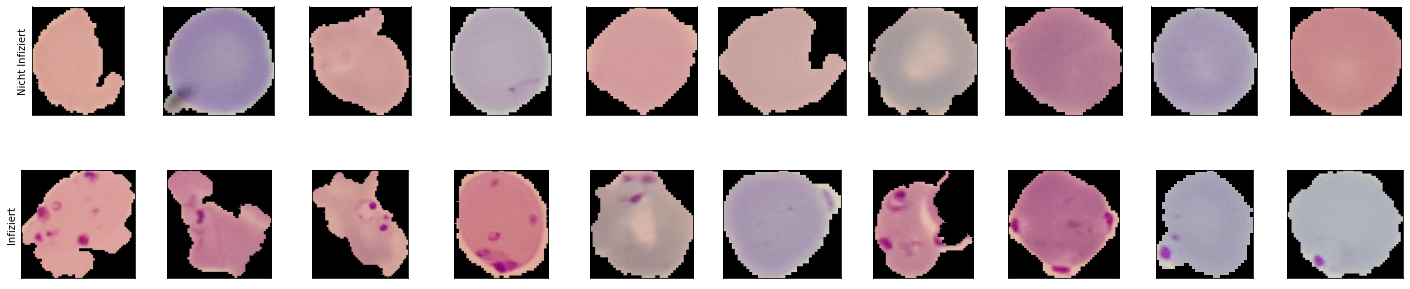

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(25, 5),
          subplot_kw={'xticks':[], 'yticks':[]},
          gridspec_kw=dict(hspace=0.5, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(Image.open(os.path.join(uninfected_dir, random.choice(os.listdir(uninfected_dir)))), cmap='binary_r')
    ax[1, i].imshow(Image.open(os.path.join(infected_dir, random.choice(os.listdir(infected_dir)))), cmap='binary_r')
    #ax[0, i].set_title(("Infected"))
ax[0, 0].set_ylabel('Nicht Infiziert')
ax[1, 0].set_ylabel('Infiziert');

                                                   
                                                   
## `** Herrausforderung 1 : Farbbilder **`
                                                   

## RGB VS. Schwarz-Weiß?

Text(0.5, 0, 'Uninfiziert - SW')

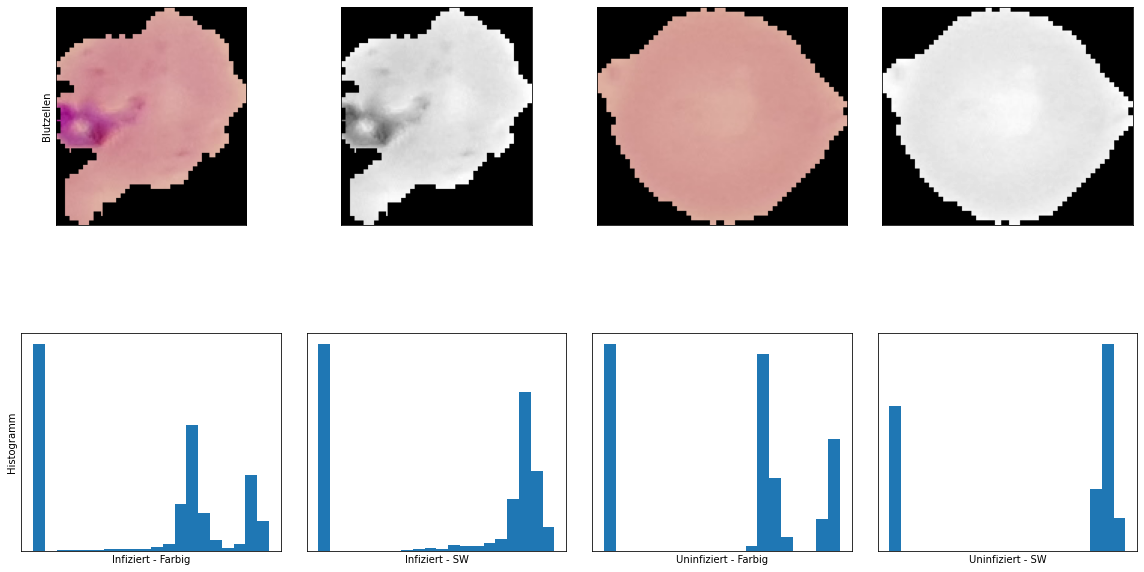

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20,10),
          subplot_kw={'xticks':[], 'yticks':[]},
          gridspec_kw=dict(hspace=0.5, wspace=0.1))
a1 = Image.open(os.path.join(infected_dir, "C100P61ThinF_IMG_20150918_144823_cell_161.png")).convert("RGB")
a2= Image.open(os.path.join(infected_dir, "C100P61ThinF_IMG_20150918_144823_cell_161.png")).convert("L")
b1= Image.open(os.path.join(uninfected_dir, "C100P61ThinF_IMG_20150918_144104_cell_128.png")).convert("RGB")
b2 = Image.open(os.path.join(uninfected_dir, "C100P61ThinF_IMG_20150918_144104_cell_128.png")).convert("L")
ax[0,0].imshow(Image.open(os.path.join(infected_dir, "C100P61ThinF_IMG_20150918_144823_cell_161.png")).convert("RGB"),cmap='binary_r')
ax[0,1].imshow(Image.open(os.path.join(infected_dir, "C100P61ThinF_IMG_20150918_144823_cell_161.png")).convert("L"),cmap='binary_r')
ax[0,2].imshow(Image.open(os.path.join(uninfected_dir, "C100P61ThinF_IMG_20150918_144104_cell_128.png")).convert("RGB"),cmap='binary_r')
ax[0,3].imshow(Image.open(os.path.join(uninfected_dir, "C100P61ThinF_IMG_20150918_144104_cell_128.png")).convert("L"),cmap='binary_r')

ax[1,0].hist(np.array(a1).flatten(), bins = 20)
ax[1,1].hist(np.array(a2).flatten(), bins = 20)
ax[1,2].hist(np.array(b1).flatten(), bins = 20)
ax[1,3].hist(np.array(b2).flatten(), bins = 20)

ax[0, 0].set_ylabel('Blutzellen')
ax[1, 0].set_ylabel('Histogramm')
ax[1, 0].set_xlabel('Infiziert - Farbig')
ax[1, 1].set_xlabel('Infiziert - SW')
ax[1, 2].set_xlabel('Uninfiziert - Farbig')
ax[1, 3].set_xlabel('Uninfiziert - SW')

Wir gehen davon aus, dass  Greyscale-Bilder gut geeigent sind, um zwischen  infizierten und nicht infizierten Zellen zu unterscheiden. 

Zusätzlich haben wir uns entschieden, Klassifikationsverfahren auch mit Farbbildern durchzuführen.



---




---



---



Inspektion Bildgrößen

In [ ]:
A =[]
for name in glob.glob("/content/cell-images-for-detecting-malaria/cell_images/Uninfected/*.png"):
  im1 = Image.open(os.path.join(infected_dir, name))
  a= im1.size
  A.append(a)
for name in glob.glob("/content/cell-images-for-detecting-malaria/cell_images/Parasitized/*.png"):
  im1 = Image.open(os.path.join(infected_dir, name))
  a= im1.size
  A.append(a)

In [ ]:
import pandas as pd 
df = pd.DataFrame(A) 
df["ratio"] = df[0]/df[1]
df.describe()

,0,1,ratio
count,27558.000000,27558.000000,27558.000000
mean,132.487154,132.983453,1.007259
std,20.015949,20.619650,0.147196
min,46.000000,40.000000,0.457831
25%,121.000000,121.000000,0.920530
50%,130.000000,130.000000,1.000000
75%,142.000000,145.000000,1.081081
max,394.000000,385.000000,2.594937


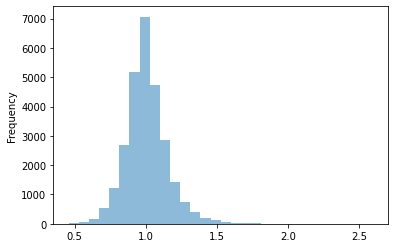

In [ ]:
b =df["ratio"]
b.plot.hist(bins=30, alpha=0.5)

                                                   
                                                   
## ** Herrausforderung 2 : Unterschiedliche Bildgröße  **

## Padding 

In [ ]:
from PIL import Image
def padding(image, max_size, method=Image.ANTIALIAS):
    """
    resize 'image' to 'max_size' keeping the aspect ratio
    and place it in center of white 'max_size' image.

    This padding function generates large frames when increasing size but leaves 
    size of those images intact. If image exceeds max_size in height or width, 
    it will however be reduced in size.
    """
    image.thumbnail(max_size, method)
    offset = (int((max_size[0] - image.size[0]) / 2), int((max_size[1] - image.size[1]) / 2))
    back = Image.new("L", max_size, "black")
    back.paste(image, offset)

    return back

In [ ]:
from PIL import Image
def padding2(image, target_size):
    """
    Apply padding to original size 'image' to square, then resize to meet target size

    This padding function generates relatively little frame but changes size of most cells
    """
    long_side = max(image.size)
    back = Image.new("L", (long_side, long_side), "black")
    offset = (int((long_side - image.size[0]) / 2), int((long_side - image.size[1]) / 2))
    back.paste(image, offset)
    newim = back.resize(target_size)

    return newim

Text(0.5, 0, '2. Padding Möglichkeit ')

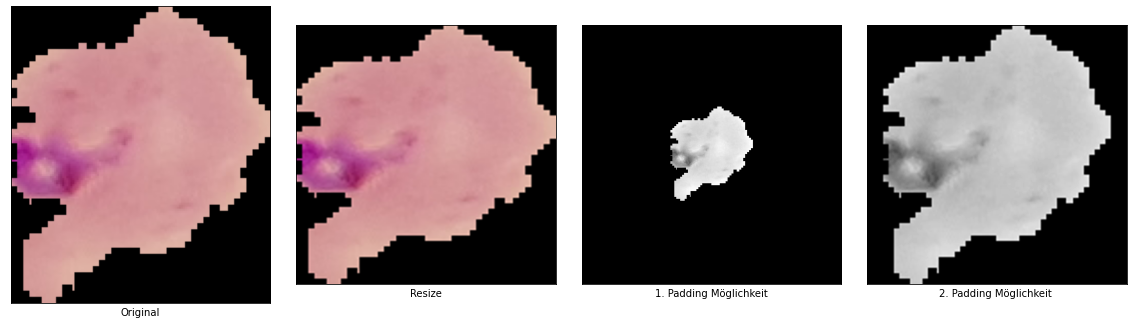

In [ ]:
im = Image.open(os.path.join(infected_dir, "C100P61ThinF_IMG_20150918_144823_cell_161.png"))
im1 = padding(im, (400,400))
im2 = padding2(im, (400,400))
im3 =im.resize((400,400))

fig, ax = plt.subplots(1, 4, figsize=(20,10),
          subplot_kw={'xticks':[], 'yticks':[]},
          gridspec_kw=dict(hspace=0.5, wspace=0.1))
ax[0].imshow(im,cmap='binary_r')
ax[1].imshow(im3,cmap='binary_r')
ax[2].imshow(im1,cmap='binary_r')
ax[3].imshow(im2,cmap='binary_r')

ax[0].set_xlabel('Original')
ax[1].set_xlabel('Resize')
ax[2].set_xlabel('1. Padding Möglichkeit')
ax[3].set_xlabel('2. Padding Möglichkeit ')

Entscheidung für Funktion padding2 zur Vorverarbeitung



---



---



---



---



---



# Daten Vorbereitung

## Daten Vorbereitung Schwarz-Weiß

### Bilddaten in numpy array laden



*   mit Standarisierung & Kontrasterhöhung 



In [ ]:
# Zielformat der Bilddaten festlegen (Length, Width - Achtung PIL / numpy untersch. Reihenfolge)
L1, L2 = (75,75)

# Trainingsdaten Uninfected laden
from PIL import Image, ImageEnhance

images_unin_contrast = []

for filename in glob.glob(os.path.join(uninfected_dir, "*.png")):

    im = Image.open(filename)
    im = padding2(im, target_size = (L1,L2))
    imc = ImageEnhance.Contrast(im).enhance(5)
    imc = np.array(imc) / 255.  # Standardisierung auf Werte zw. 0 & 1
    images_unin_contrast.append(imc.flatten())

images_unin_contrast = np.array(images_unin_contrast)


# Trainingsdaten Parasitized laden
images_para_contrast = []

for filename in glob.glob(os.path.join(infected_dir, "*.png")):

    im = Image.open(filename)
    im = padding2(im, target_size = (L1,L2))
    imc = ImageEnhance.Contrast(im).enhance(5)
    imc = np.array(imc) / 255. 
    images_para_contrast.append(imc.flatten())

images_para_contrast = np.array(images_para_contrast)

### Zielvariable erzeugen

In [ ]:
y_unin = np.zeros(len(images_unin_contrast))
y_para = np.ones(len(images_para_contrast))

y_full = np.concatenate((y_unin, y_para))
print(y_unin.shape, y_para.shape)
y_full.shape

(13779,) (13779,)


(27558,)

In [ ]:
X_full = np.concatenate((images_unin_contrast, images_para_contrast))
X_full.shape

(27558, 5625)

### Datenpunkte reduzieren wg. Rechenzeit

In [ ]:
from sklearn.model_selection import train_test_split
X_train, _, y_train, _ = train_test_split(X_full, y_full, test_size=0.5, stratify = y_full) 
# mit stratify = y könnte sicher gegangen werden dass y in train und test-daten gleich verteilt ist - bei dieser Fallzahl nicht nötig
for i in [X_train, y_train]:
  print(i.shape)

(13779, 5625)
(13779,)


### Trainings- und Testdaten erzeugen

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train) 
for i in [X_train, X_test, y_train, y_test]:
  print(i.shape)

(11023, 5625)
(2756, 5625)
(11023,)
(2756,)


### Feature selection

####Principal Component Analysis
#####Komponentenzahl ermitteln

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(400)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=400, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

wie viele components sind nötig für 90% explained variance?

Text(0, 0.5, 'Erklärte Varianz i. Komponent')

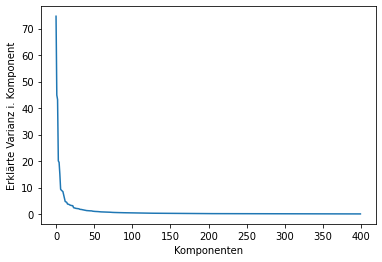

In [ ]:
plt.figure()
plt.plot(pca.explained_variance_)
plt.xlabel("Komponenten")
plt.ylabel("Erklärte Varianz i. Komponent")

Text(0.5, 1.0, 'Scree Plot')

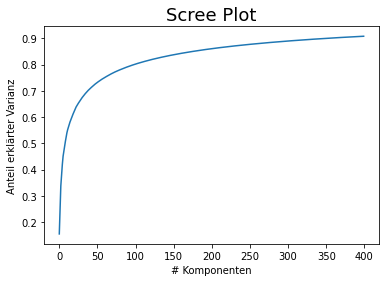

In [ ]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# Komponenten")
plt.ylabel("Anteil erklärter Varianz")
plt.title("Scree Plot", fontsize = 18)

 PCA mit ca. 350 Komponenten berechnen zur Verwendung in den Klassifikationsmodellen

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

(11023, 355) (2756, 355)


#### Visualisierung der PCA-Komponenten
Den Durchschnitts-Eigenvektor und die ersten 19 PCA-Komponenten anzeigen

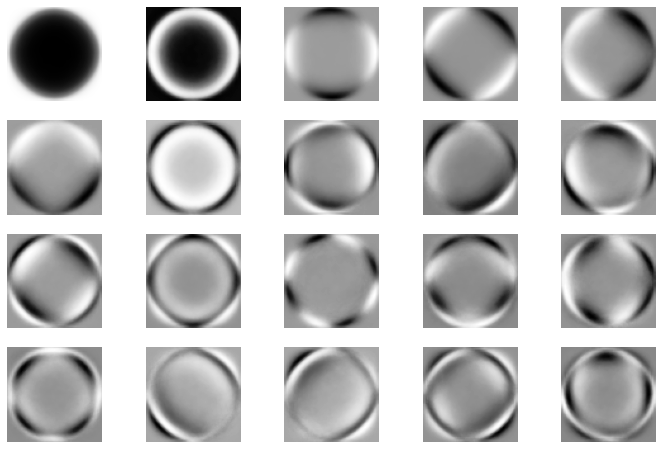

In [ ]:
from PIL import Image
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 5, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
  if i==0:
    component = pca.mean_ 
  else:
    component = pca.components_[i-1, :]
  ax.imshow(component.reshape(L1,L2), cmap="Greys")
  ax.axis("off")  

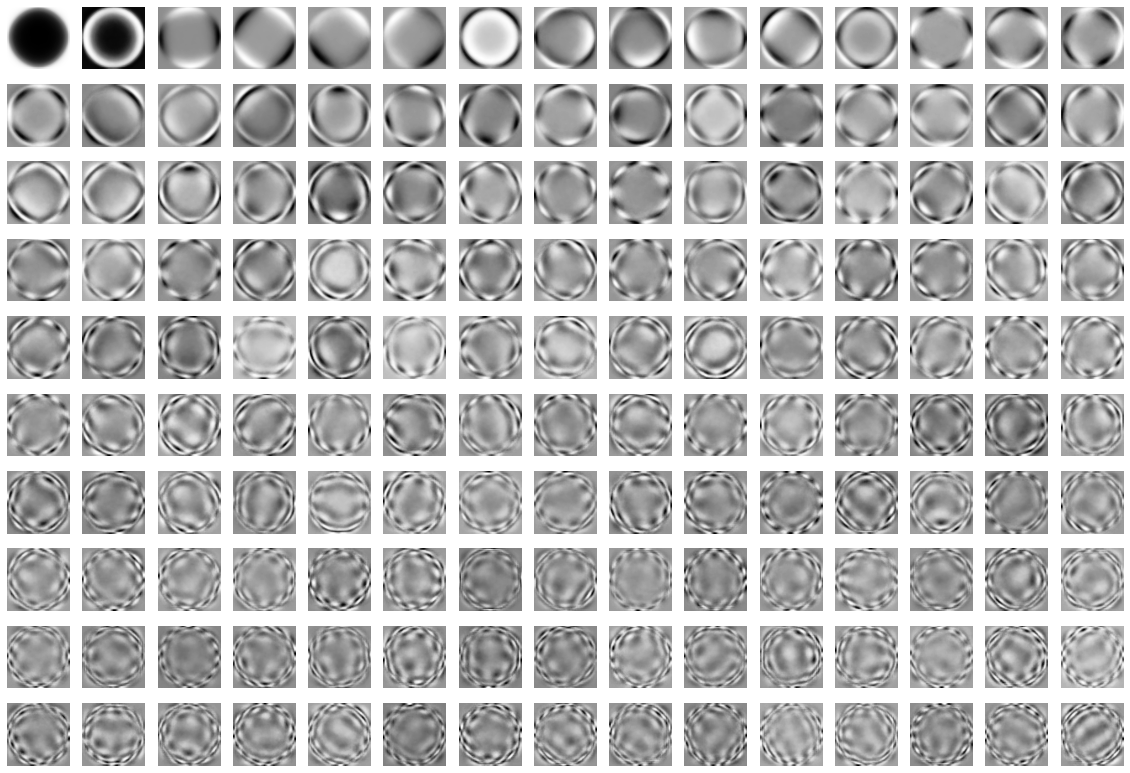

In [ ]:
fig, axes = plt.subplots(10, 15, figsize=(20, 14))

for i, ax in enumerate(axes.flatten()):
  if i==0:
    component = pca.mean_ 
  else:
    component = pca.components_[i-1, :]
  ax.imshow(component.reshape(L1,L2), cmap="Greys")
  ax.axis("off")  

In [ ]:
projected = pca.inverse_transform(X_train_transformed)

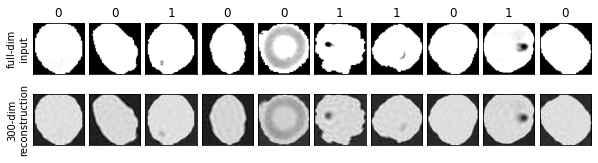

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(X_train[i].reshape(L1,L2), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(L1,L2), cmap='binary_r')
    ax[0, i].set_title(int(y_train[i]))
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('300-dim\nreconstruction');

###Datenvorbereitung RGB

In [44]:
#padding Funktion _RGB

from PIL import Image
def padding2(image, target_size):
    """
    Apply padding to original size 'image' to square, then resize to meet target size

    This padding function generates relatively little frame but changes size of most cells
    """
    long_side = max(image.size)
    back = Image.new("RGB", (long_side, long_side), "black")
    offset = (int((long_side - image.size[0]) / 2), int((long_side - image.size[1]) / 2))
    back.paste(image, offset)
    newim = back.resize(target_size)

    return newim

In [45]:
# Contrast - RGB 
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

In [52]:
# Trainingsdaten Uninfected laden
from PIL import Image, ImageEnhance
from PIL import Image
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

W = W1 = L = L1 = 50 # 
images_unin_f = []

i = 0
# Trainingsdaten Uninfected laden
for filename in glob.glob("/content/cell-images-for-detecting-malaria/cell_images/Uninfected/*.png"):
    im = Image.open(filename)
    l, w= im.size 
    im = im.convert("RGB") # Bilder L
    im = change_contrast(im, 100)
    im = padding2(im, target_size = (L,W))
    im = np.array(im) / 255.
    images_unin_f.append(im.flatten())
  
    i = i +1
    if i==5000:
      break    
images_unin_f = np.array(images_unin_f) 

# Trainingsdaten Parasitized laden
images_para_f = []
i = 0
for filename in glob.glob("/content/cell-images-for-detecting-malaria/cell_images/Parasitized/*.png"):
    im = Image.open(filename)
    l, w= im.size 
    im = im.convert("RGB") # Bilder L
    im = change_contrast(im, 100)
    im =padding2(im, target_size = (L,W))
    im = np.array(im) / 255.
    images_para_f.append(im.flatten())
  
    i = i +1
    if i==5000:
      break
images_para_f = np.array(images_para_f) 

In [ ]:
filename = os.path.join(infected_dir, random.choice(os.listdir(infected_dir)))

In [ ]:
im = Image.open(filename)
l, w= im.size 
im = im.convert("RGB")
im = change_contrast(im, 100)
im =padding2(im, target_size = (L,W))
im = np.array(im) / 255.
#images_para_f.append(im.flatten())

In [ ]:
np.array(im).shape

(75, 75, 3)

In [ ]:
im.flatten().shape

(16875,)

### Zielvariable erzeugen

In [53]:
y_unin = np.zeros(len(images_unin_f))
y_para = np.ones(len(images_para_f))

y_full_f = np.concatenate((y_unin, y_para))
y_full_f.shape

(10000,)

In [54]:
X_full_f = np.concatenate((images_unin_f, images_para_f))
X_full_f.shape

(10000, 7500)

## Trainings- und Testdaten erzeugen

In [55]:
from sklearn.model_selection import train_test_split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full_f, y_full_f, test_size=0.2, stratify = y_full_f)

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9)
pca.fit(X_train_f)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [57]:
X_train_transformed_f = pca.transform(X_train_f)
X_test_transformed_f = pca.transform(X_test_f)
print(X_train_transformed_f.shape, X_test_transformed_f.shape)

(8000, 148) (2000, 148)


In [58]:
component = pca.components_[0, :]
component.shape # L*W*3

(7500,)

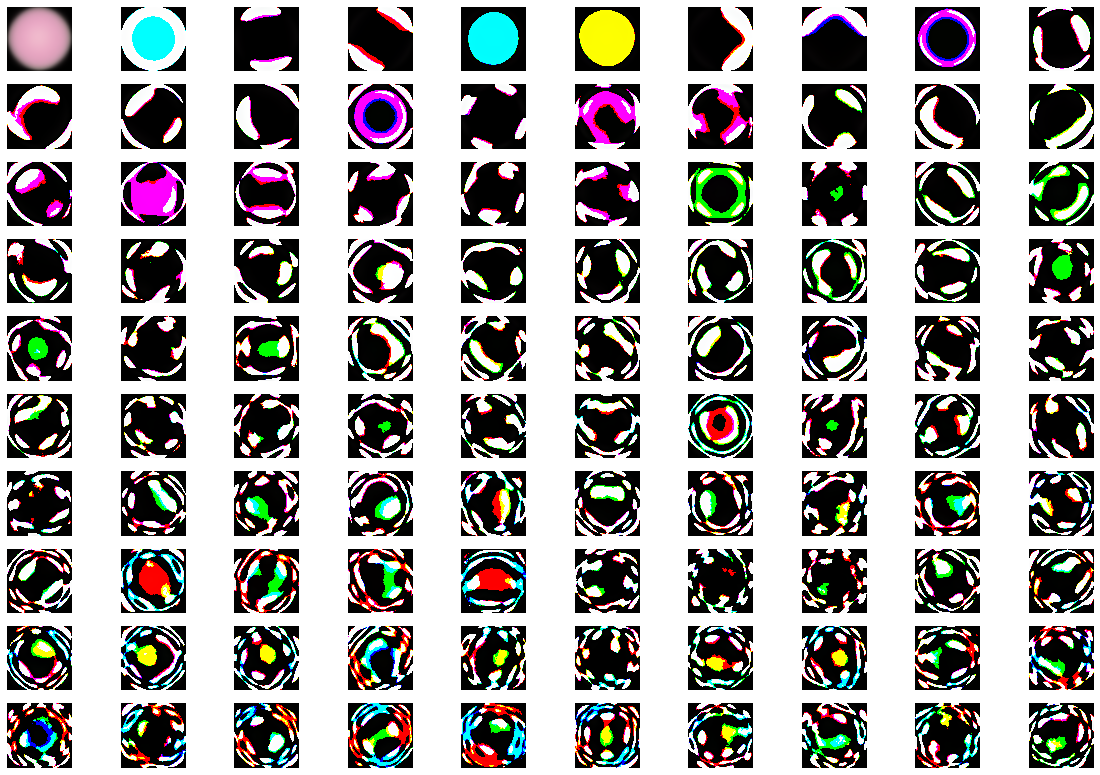

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(20, 14))

for i, ax in enumerate(axes.flatten()):
  if i==0:
    component = pca.mean_ 
  else:
    component = pca.components_[i-1, :]
  ax.imshow((component.reshape(W,L,3)*255).astype(np.uint8))
  ax.axis("off")  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

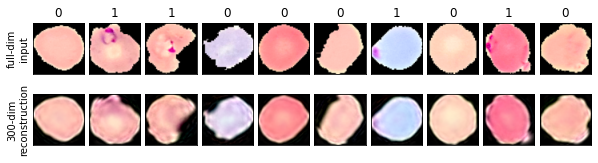

In [ ]:
projected_f = pca.inverse_transform(X_train_transformed_f)
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(X_train_f[i].reshape(W1,W,3), cmap='binary_r')
    ax[1, i].imshow(projected_f[i].reshape(W1,W,3), cmap='binary_r')
    ax[0, i].set_title(int(y_train_f[i]))
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('300-dim\nreconstruction');



---



---



---



---



---


# ML-Modelle Trainieren


## SVC
Baseline Modell

### Schwarz-weiß


In [ ]:
from sklearn.svm import SVC
svm_classifier_pca = SVC(kernel="rbf", gamma="scale")
svm_classifier_pca.fit(X_train_transformed, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm_classifier_pca.score(X_test_transformed, y_test)

0.7365747460087083

### RGB

In [59]:
from sklearn.svm import SVC
svm_classifier_pca = SVC(kernel="rbf", gamma="scale")
svm_classifier_pca.fit(X_train_transformed_f, y_train_f)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
svm_classifier_pca.score(X_test_transformed_f, y_test_f)

0.7115

###Support Vector Classifier Crossvalidierung **Hyperparamter Tuning**

SW - **Bestes Model** 

In [36]:
from sklearn.svm import SVC
from time import time
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
Cs = np.logspace(3, 4, 4)
gammas = np.logspace(-5, -3, 4)
gammas = list(gammas)
print(Cs, gammas)

[ 1000.          2154.43469003  4641.58883361 10000.        ] [1e-05, 4.641588833612782e-05, 0.00021544346900318823, 0.001]


In [ ]:
#Cs = np.logspace(2, 5, 5)
#gammas = np.logspace(-6, -2, 5)

Cs = np.logspace(3, 4, 4)
gammas = np.logspace(-5, -3, 4)

# Train SVC model with GridSearchCV - takes a while

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': Cs,
              'gamma': gammas,
              }

meta_model_hp_tuning = GridSearchCV(
    SVC(kernel = 'rbf'), 
    param_grid = param_grid,
    scoring="accuracy",
    cv=4,
    n_jobs = -1 # use all available processors
)
meta_model_hp_tuning = meta_model_hp_tuning.fit(X_train_transformed, y_train)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 3854.246s


In [ ]:
print("Bestes Modell in durch Gridsearch:")
print(meta_model_hp_tuning.best_estimator_)

Bestes Modell in durch Gridsearch:
SVC(C=10000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=4.641588833612782e-05,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [ ]:
# Quantitative Evaluation der Modellqualität auf den Test-Daten

print(f"Best model has parameters {meta_model_hp_tuning.best_params_} and score of {round(meta_model_hp_tuning.best_score_,3)}")

print("Predicting malaria cell status")
t0 = time()
y_pred = meta_model_hp_tuning.predict(X_test_transformed)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#print(meta_model_hp_tuning.cv_results_["mean_test_score"])

Best model has parameters {'C': 10000.0, 'gamma': 4.641588833612782e-05} and score of 0.757
Predicting malaria cell status
done in 10.858s
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77      1378
         1.0       0.79      0.71      0.75      1378

    accuracy                           0.76      2756
   macro avg       0.76      0.76      0.76      2756
weighted avg       0.76      0.76      0.76      2756

[[1112  266]
 [ 399  979]]


Das beste Support Vector Classifier Modell mit Parametern:<br>
*kernel = 'rbf', C = 10000.0, gamma =  4.64e-05* erreicht <br>
**0.76% accuracy auf den Testdaten**

RGB - **Bestes Model** 

In [61]:
from sklearn.svm import SVC
svm_classifier_pca = SVC(kernel="rbf", gamma= 4.64e-05, C=10000)
svm_classifier_pca.fit(X_train_transformed_f, y_train_f)


SVC(C=10000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=4.64e-05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [62]:
svm_classifier_pca.score(X_test_transformed_f, y_test_f)

0.7125

### RandomForestClassifier - SW

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RandomForestClassifier(n_jobs=-1).fit(X_train_transformed, y_train).score(X_test_transformed, y_test)

0.7336719883889695

Random Forest Hyperparameter Tuning

In [ ]:
# Train RandomForest classification model with GridSearchCV

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'max_depth': [10, 25, 50, 100, None],
              'n_estimators': [100,150,300],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
              }

meta_model_hp_tuning = GridSearchCV(
    RandomForestClassifier(n_jobs =-1, max_features = 'sqrt'), 
    param_grid = param_grid,
    scoring="accuracy",
    cv=5
)
meta_model_hp_tuning = meta_model_hp_tuning.fit(X_train_transformed, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(meta_model_hp_tuning.best_estimator_)

Fitting the classifier to the training set
done in 19472.457s
Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [37]:
# Quantitative Evaluation der Modellqualität auf den Test-Daten

#print(f"Best model has parameters {meta_model_hp_tuning.best_params_} and score of {round(meta_model_hp_tuning.best_score_,2)}")

print("Predicting malaria cell status")
t0 = time()
y_pred = meta_model_hp_tuning.predict(X_test_transformed)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#print(meta_model_hp_tuning.cv_results_["mean_test_score"])

Predicting malaria cell status
done in 0.313s
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      1378
         1.0       0.73      0.80      0.76      1378

    accuracy                           0.75      2756
   macro avg       0.76      0.75      0.75      2756
weighted avg       0.76      0.75      0.75      2756

[[ 982  396]
 [ 281 1097]]


Das beste BW Random Forest Classifier Modell mit Parametern:<br>
*n_estimators=300, max_features = 'sqrt', max_depth = 50,  min_samples_leaf=2, min_samples_split=5, n_jobs = -1 (nur Laufzeitrelevanz)* erreicht <br>
**0.75% accuracy auf den Testdaten**

### RandomForestClassifier - RGB

In [65]:
from time import time
from sklearn.ensemble import RandomForestClassifier
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Train RandomForest classification model with GridSearchCV

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'max_depth': [25, 50, 100],
              'max_features': ['sqrt'],
              'n_estimators': [300],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4] }

meta_model_hp_tuning = GridSearchCV(
  RandomForestClassifier(max_features = 'sqrt', n_jobs = -1), 
  param_grid = param_grid,
  scoring="accuracy",
  cv=5
)
meta_model_hp_tuning = meta_model_hp_tuning.fit(X_train_transformed_f, y_train_f)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(meta_model_hp_tuning.best_estimator_)

Fitting the classifier to the training set
done in 2532.925s
Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [67]:
# Quantitative evaluation of the model quality on the test set

print(f"Best model has parameters {meta_model_hp_tuning.best_params_} and score of {round(meta_model_hp_tuning.best_score_,2)}")

print("Predicting malaria cell status")
t0 = time()
y_pred_f = meta_model_hp_tuning.predict(X_test_transformed_f)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test_f, y_pred_f)) #target_names=target_names
print(confusion_matrix(y_test_f, y_pred_f)) #, labels=range(n_classes)
print(meta_model_hp_tuning.cv_results_["mean_test_score"])

Best model has parameters {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300} and score of 0.71
Predicting malaria cell status
done in 0.210s
              precision    recall  f1-score   support

         0.0       0.76      0.64      0.70      1000
         1.0       0.69      0.80      0.74      1000

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.72      0.72      2000

[[642 358]
 [200 800]]
[0.694625 0.696875 0.6995   0.697375 0.697    0.701375 0.69775  0.69875
 0.69925  0.70075  0.706    0.69925  0.6955   0.7015   0.69925  0.69575
 0.696375 0.701625 0.70075  0.7015   0.697875 0.697125 0.701375 0.70125
 0.695625 0.690875 0.69675 ]


Das beste RGB Random Forest Classifier Modell mit Parametern:<br>
*n_estimators=300, max_features = 'sqrt', max_depth = 50,  min_samples_leaf=1, min_samples_split=5, n_jobs = -1 (nur Laufzeitrelevanz)* erreicht <br>
**0.72% accuracy auf den Testdaten**

### kNN Classifier - SW
mit Crossvalidierung Hyperparametersuche

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
knn = KNeighborsClassifier(n_neighbors = 3, n_jobs = 8)

In [40]:
knn.fit(X_train_transformed, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=3, p=2,
                     weights='uniform')

In [41]:
knn.score(X_test_transformed, y_test)

0.5540638606676342

In [42]:
# Train a KNN classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'n_neighbors': [2,3,4,5,6]}

meta_model_hp_tuning = GridSearchCV(
    KNeighborsClassifier(n_jobs = -1), 
    param_grid = param_grid,
    scoring="accuracy",
    cv=5
)
meta_model_hp_tuning = meta_model_hp_tuning.fit(X_train_transformed, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(meta_model_hp_tuning.best_estimator_)

Fitting the classifier to the training set
done in 267.767s
Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')


In [43]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print(f"Best model has parameters {meta_model_hp_tuning.best_params_} and score of {round(meta_model_hp_tuning.best_score_,2)}")

print("Predicting malaria cell status")
t0 = time()
y_pred = meta_model_hp_tuning.predict(X_test_transformed)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred)) 
print(confusion_matrix(y_test, y_pred)) 
print(meta_model_hp_tuning.cv_results_["mean_test_score"])

Best model has parameters {'n_neighbors': 3} and score of 0.55
Predicting malaria cell status
done in 12.903s
              precision    recall  f1-score   support

         0.0       0.53      0.86      0.66      1378
         1.0       0.64      0.25      0.35      1378

    accuracy                           0.55      2756
   macro avg       0.59      0.55      0.51      2756
weighted avg       0.59      0.55      0.51      2756

[[1189  189]
 [1040  338]]
[0.525537   0.55048553 0.52617245 0.54059714 0.52508365]


In [ ]:
meta_model_hp_tuning.cv_results_["mean_test_score"]

array([0.51825783, 0.54558839, 0.5272177 , 0.54683742, 0.52631119,
       0.54014557, 0.53027957])

knn Modelle kommen mit max. 55% Accuracy auf Testdaten nicht an die Genauigkeit von SVC und Random Forest heran.